In [1]:
import re
import pandas

In [2]:
def normalize_vendor_name(name):
    """
    Normalize vendor name by:
    - Converting to lowercase
    - Removing punctuation
    - Stripping leading and trailing whitespace
    """
    for magic_name in ['DDN', 'KAYTUS', 'Eviden', 'Carahsoft', 'Boston Limited', 'NVIDIA', 'CIQ', 'NetApp', "Run:ai", "DUG", "DDC", 'Seagate', 'TU Dresden', 'croit', 'Texas A&M', 'University of Southern California', 'MiTAC', 'NCSA', 'Pawsey', 'A*STAR', 'Rittal', 'iM', 'Iris Energy', 'Asia Supercomputer Community', 'SSSTC', 'Apaltek']:
        if magic_name in name:
            name = magic_name

    for old_name, new_name in {
            'Tyan': "MiTAC",
            'Panasas': "VDURA",
            'ASTAR': "A*STAR",
            'Tokyo Institute of Technology': 'Institute of Science Tokyo',
            'Boston Limited': 'SourceCode',
            'Boston Limited / Source Code': 'SourceCode',
            'Sunshine State Education And Research Computing Alliance': "SSERCA",
            'PSNC & PIONIER - Polish Optical Internet': 'PSNC/PIONIER - Polish Optical Internet',
            'Gnosis Research Center - Illinois Institute of Technology': "Illinois Tech",
            'CGG': "Viridien",
        }.items():
        if old_name in name:
            name = new_name
    
    name = name.lower()  # Convert to lowercase
    name = re.sub(r"[^\w\s]", "", name)  # Remove punctuation
    # replace consecutive whitespace with one whitespace
    name = re.sub(r"\s+", " ", name)
    name.strip()
    return name

In [3]:
sc23_exhibitors = pandas.read_csv('sc23-exhibitors.csv')
sc24_exhibitors = pandas.read_csv('sc24-exhibitors.csv')

# drop rows where 'booth number' contains non-numeric characters (these are whisper suites)
sc23_exhibitors = sc23_exhibitors[sc23_exhibitors['booth number'].str.isnumeric()]
sc24_exhibitors = sc24_exhibitors[sc24_exhibitors['booth number'].str.isnumeric()]

# print duplicate 'company name' values in each dataframe
print('SC23 duplicates companies:')
print(sc23_exhibitors[sc23_exhibitors.duplicated('company name', keep=False)].sort_values('company name'))
print('SC24 duplicates companies:')
print(sc24_exhibitors[sc24_exhibitors.duplicated('company name', keep=False)].sort_values('company name'))

# print duplicate 'booth number' values in each dataframe
for df in [sc23_exhibitors, sc24_exhibitors]:
    duplicate_booths = df[df.duplicated('booth number', keep=False)]
    if not duplicate_booths.empty:
        print('Duplicate booths:')
        print(duplicate_booths.sort_values('booth number'))
        raise ValueError('Duplicate booths found')

# delete all rows from both dataframes where company name is 'dNOC'
for drop_vendors in [
        'dNOC',
        'Student Cluster Challenge',
        'SCinet',
        'SCinet Theater',
        'Attendee Lounge sponsored by Vultr',
        'HPC Illuminations Pavilion',
        'SC24 Headshot Lounge',
        'SCinet Research Exposition',
        'Open Standards Pavilion',
    ]:
    sc23_exhibitors = sc23_exhibitors[sc23_exhibitors['company name'] != drop_vendors]
    sc24_exhibitors = sc24_exhibitors[sc24_exhibitors['company name'] != drop_vendors]

sc23_exhibitors['normalized company name'] = sc23_exhibitors['company name'].apply(normalize_vendor_name)
sc24_exhibitors['normalized company name'] = sc24_exhibitors['company name'].apply(normalize_vendor_name)

sc23_exhibitors.columns = ['sc23' + " " + column for column in sc23_exhibitors.columns]
sc24_exhibitors.columns = ['sc24' + " " + column for column in sc24_exhibitors.columns]

sc23_exhibitors.head()

SC23 duplicates companies:
                   company name booth number  booth area sqft
147                        ASUS          257              600
34                         ASUS          298              225
199                      Altair          825              600
31                       Altair          116              256
44                    Ayar Labs          499              225
140                   Ayar Labs          228              200
41                     BittWare         2333              225
269                    BittWare         1249              400
36                    Carahsoft          498              225
160                   Carahsoft          371              800
231           Cornelis Networks          599              225
152           Cornelis Networks          281              600
420                   Enfabrica          586              200
415                   Enfabrica          798              225
158                    GIGABYTE          35

,sc23 company name,sc23 booth number,sc23 booth area sqft,sc23 normalized company name
0,atNorth,289,200,atnorth
1,Arcitecta,795,200,arcitecta
2,National Security Agency (NSA),892,200,national security agency nsa
3,Quandela,2601,400,quandela
4,SQream,2501,100,sqream


In [4]:

# Step 2: Join both dataframes on common company names
merged_df = pandas.merge(sc23_exhibitors, sc24_exhibitors, left_on="sc23 normalized company name", right_on="sc24 normalized company name", how="outer")

# Step 3: Fill in the rows using repeated data
merged_df = merged_df.sort_values(by=["sc23 company name", "sc24 company name"]).reset_index(drop=True)
merged_df['canonical name'] = merged_df['sc23 normalized company name'].combine_first(merged_df['sc24 normalized company name'])

# for cases where canonical name is duplicated, only retain the row which has the highest value for either sc23 booth area sqft or sc24 booth area sqft
merged_df['max booth area sqft'] = merged_df[['sc23 booth area sqft', 'sc24 booth area sqft']].max(axis=1)
merged_df = merged_df.sort_values(by="max booth area sqft", ascending=False)
merged_df = merged_df.drop_duplicates(subset="canonical name", keep="first")

# now calculate the increase in square footage from sc23 to sc24. for booths that didn't exist in sc23, their sqft should be 0.
merged_df['sc23 booth area sqft'] = merged_df['sc23 booth area sqft'].fillna(0)
merged_df['sc24 booth area sqft'] = merged_df['sc24 booth area sqft'].fillna(0)
merged_df['sqft increase'] = merged_df['sc24 booth area sqft'] - merged_df['sc23 booth area sqft']
merged_df['sqft abs change'] = merged_df['sqft increase'].abs()

merged_df.sort_values(by="sqft abs change", inplace=True, ascending=False)

summary_df = merged_df[['canonical name', 'sc23 booth area sqft', 'sc24 booth area sqft', 'sqft increase']].copy()

# save merged_df
merged_df.to_csv('_sc23_sc24_merged.csv', index=False)
# save summary_df
summary_df.to_csv('_sc23_sc24_summary.csv', index=False)

summary_df

,canonical name,sc23 booth area sqft,sc24 booth area sqft,sqft increase
106,dell technologies,1500.0,3200.0,1700.0
200,korea semiconductor industry association,2500.0,900.0,-1600.0
573,stulz,0.0,1600.0,1600.0
150,hlrs,900.0,2500.0,1600.0
393,usystems brand of legrand,400.0,2000.0,1600.0
...,...,...,...,...
41,beehe electric taicang coltd,200.0,200.0,0.0
101,danfoss power solutions,200.0,200.0,0.0
396,university at buffalo center for computational...,200.0,200.0,0.0
398,university of kentucky,200.0,200.0,0.0


In [5]:
# Find all vendors who disappeared from SC24
disappeared_vendors = merged_df[merged_df['sc24 normalized company name'].isnull()].sort_values('sqft abs change', ascending=False)
display(disappeared_vendors)

# find all vendors who appeared in SC24
appeared_vendors = merged_df[merged_df['sc23 normalized company name'].isnull()].sort_values('sqft abs change', ascending=False)
display(appeared_vendors)

,sc23 company name,sc23 booth number,sc23 booth area sqft,sc23 normalized company name,sc24 company name,sc24 booth number,sc24 booth area sqft,sc24 normalized company name,canonical name,max booth area sqft,sqft increase,sqft abs change
364,Symbiosys Alliance,1955,600.0,symbiosys alliance,NaN,NaN,0.0,NaN,symbiosys alliance,600.0,-600.0,600.0
335,SUSE LLC,535,600.0,suse llc,NaN,NaN,0.0,NaN,suse llc,600.0,-600.0,600.0
370,Tenstorrent,1707,600.0,tenstorrent,NaN,NaN,0.0,NaN,tenstorrent,600.0,-600.0,600.0
108,DigitalOcean,331,400.0,digitalocean,NaN,NaN,0.0,NaN,digitalocean,400.0,-400.0,400.0
240,NEUCHIPS INC.,2099,400.0,neuchips inc,NaN,NaN,0.0,NaN,neuchips inc,400.0,-400.0,400.0
...,...,...,...,...,...,...,...,...,...,...,...,...
177,Intelligent Light,1715,100.0,intelligent light,NaN,NaN,0.0,NaN,intelligent light,100.0,-100.0,100.0
185,"JMc Global TechnologiesI, L.P.",970,100.0,jmc global technologiesi lp,NaN,NaN,0.0,NaN,jmc global technologiesi lp,100.0,-100.0,100.0
274,OpenPOWER Foundation,1835,100.0,openpower foundation,NaN,NaN,0.0,NaN,openpower foundation,100.0,-100.0,100.0
350,SmartSoC Solutions Inc,2213,100.0,smartsoc solutions inc,NaN,NaN,0.0,NaN,smartsoc solutions inc,100.0,-100.0,100.0


,sc23 company name,sc23 booth number,sc23 booth area sqft,sc23 normalized company name,sc24 company name,sc24 booth number,sc24 booth area sqft,sc24 normalized company name,canonical name,max booth area sqft,sqft increase,sqft abs change
573,NaN,NaN,0.0,NaN,STULZ,1748,1600.0,stulz,stulz,1600.0,1600.0,1600.0
575,NaN,NaN,0.0,NaN,"Samsung Semiconductor, Inc.",3314,900.0,samsung semiconductor inc,samsung semiconductor inc,900.0,900.0,900.0
540,NaN,NaN,0.0,NaN,"NetApp, Inc.",3302,900.0,netapp,netapp,900.0,900.0,900.0
474,NaN,NaN,0.0,NaN,Delta Electronics (Americas) Ltd.,1251,800.0,delta electronics americas ltd,delta electronics americas ltd,800.0,800.0,800.0
444,NaN,NaN,0.0,NaN,Ansys,2741,800.0,ansys,ansys,800.0,800.0,800.0
...,...,...,...,...,...,...,...,...,...,...,...,...
491,NaN,NaN,0.0,NaN,Frazier & Deeter,1501,100.0,frazier deeter,frazier deeter,100.0,100.0,100.0
544,NaN,NaN,0.0,NaN,"Panmnesia, Inc.",3934,100.0,panmnesia inc,panmnesia inc,100.0,100.0,100.0
545,NaN,NaN,0.0,NaN,ParTec AG,744,100.0,partec ag,partec ag,100.0,100.0,100.0
522,NaN,NaN,0.0,NaN,"Lintes Technology Co., Ltd.",446,100.0,lintes technology co ltd,lintes technology co ltd,100.0,100.0,100.0


In [6]:
import matplotlib.pyplot
import squarify
import numpy

USE_TOP = 20

Text(0.5, 1.0, 'Top disappeared vendors')

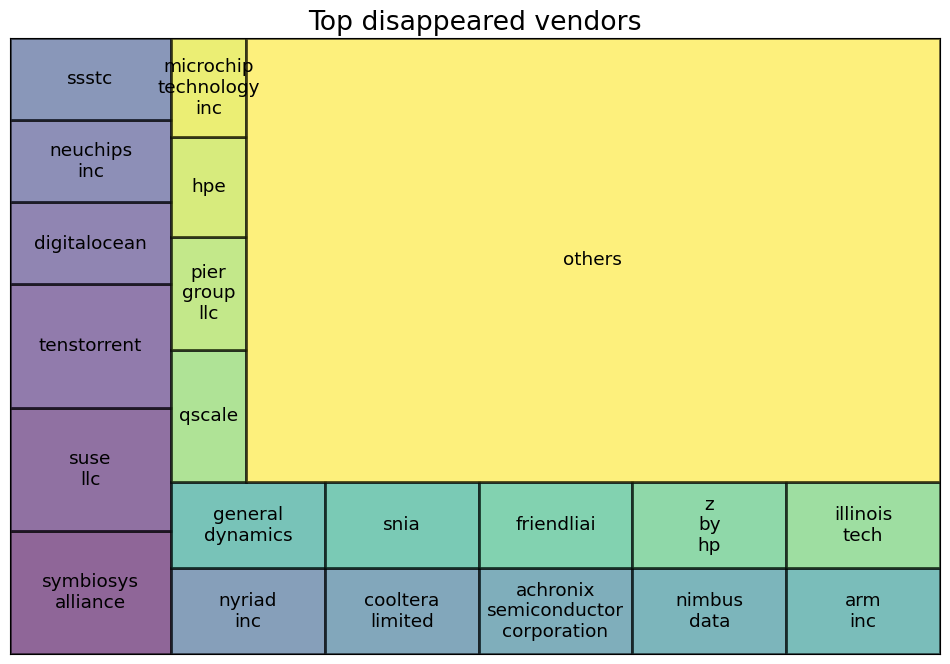

In [7]:
top_disappeared_vendors = disappeared_vendors.head(USE_TOP)[['canonical name', 'sqft increase']].set_index('canonical name').copy()
top_disappeared_vendors.loc['others'] = disappeared_vendors.iloc[USE_TOP:].sum()

colors = matplotlib.pyplot.cm.viridis(numpy.linspace(0, 1, USE_TOP + 1))

fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(12, 8))
squarify.plot(
    sizes=top_disappeared_vendors['sqft increase'].abs(),
    label=[x.replace(' ', '\n') for x in top_disappeared_vendors.index.values],
    color=colors,
    alpha=0.6, ax=ax, edgecolor='black', linewidth=2, text_kwargs={'fontsize': 'small'})
# disable x/y ticks and ticklabels
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Top disappeared vendors')

Text(0.5, 1.0, 'Top new vendors')

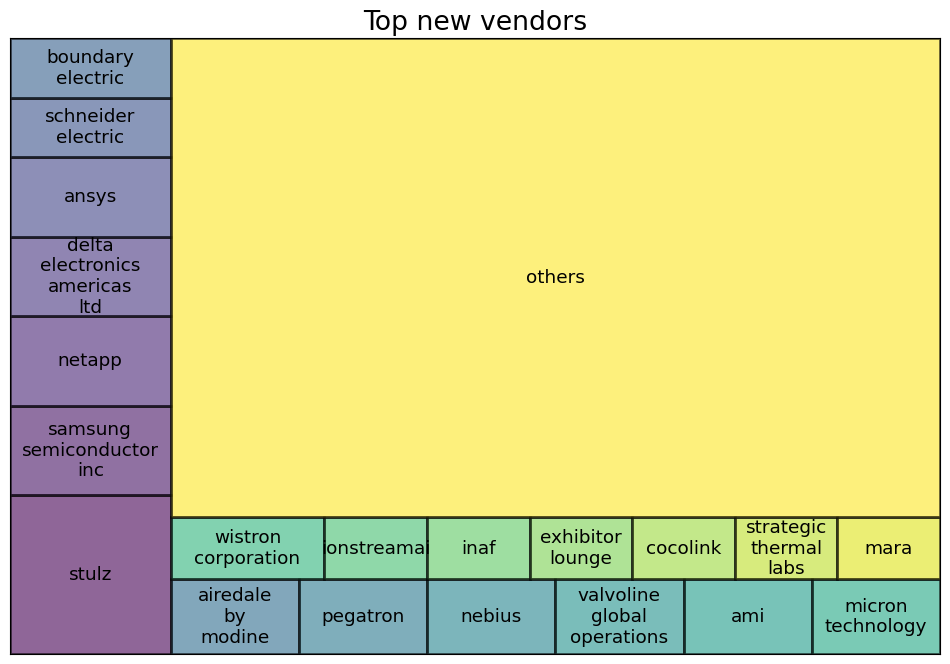

In [8]:
top_new_vendors = appeared_vendors.head(USE_TOP)[['canonical name', 'sqft increase']].set_index('canonical name').copy()
top_new_vendors.loc['others'] = appeared_vendors.iloc[USE_TOP:].sum()

colors = matplotlib.pyplot.cm.viridis(numpy.linspace(0, 1, USE_TOP + 1))

fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(12, 8))
squarify.plot(
    sizes=top_new_vendors['sqft increase'].abs(),
    label=[x.replace(' ', '\n') for x in top_new_vendors.index.values],
    color=colors,
    alpha=0.6, ax=ax, edgecolor='black', linewidth=2, text_kwargs={'fontsize': 'small'})
# disable x/y ticks and ticklabels
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Top new vendors')